# 머신러닝을 이용한 가뭄예측

## 한글데이터 처리를 위한 사전작업

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

**(Runtime 재시작 필요)**

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
mpl.rc('font', family=font_name)
mpl.font_manager._rebuild()

## 데이터 수집
- 기상자료개방포털(https://data.kma.go.kr)에서 다운로드 
- Feature: 종관기상관측(ASOS)
- Label: 표준강수지수

## 데이터 가공

### 파일 읽기

In [3]:
import os

# files = os.listdir('/content')
files = os.listdir('/content/drive/MyDrive/ml_repo-3')
asos_csv_files = [file for file in files if file.startswith("OBS_ASOS_")]
asos_csv_files[:2]

['OBS_ASOS_DD_19900701_19901231.csv', 'OBS_ASOS_DD_20210101_20220531.csv']

In [4]:
import pandas as pd

tmp = []
for csv_file in asos_csv_files:
  # tmp.append(pd.read_csv('/content/' + csv_file, encoding='euc-kr'))
  tmp.append(pd.read_csv('/content/drive/MyDrive/ml_repo-3/' + csv_file, encoding='euc-kr'))

asos_raw = pd.concat(tmp)
asos_raw.head(2)

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 풍속(m/s),평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa)
0,90,속초,1990-07-01,16.5,14.9,19.5,0.3,2.2,15.2,92.0,1012.8
1,90,속초,1990-07-02,16.2,14.9,17.2,21.3,3.2,15.6,95.5,1008.8


In [5]:
asos = asos_raw[['지점', '일시'
                , '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '평균 현지기압(hPa)'
                , '일강수량(mm)', '평균 풍속(m/s)', '평균 이슬점온도(°C)', '평균 상대습도(%)']].copy()
asos.rename(columns = {
    '평균기온(°C)' : '평균기온',
    '최저기온(°C)' : '최저기온',
    '최고기온(°C)' : '최고기온',
    '평균 현지기압(hPa)' : '기압',
    '일강수량(mm)' : '강수량',
    '평균 풍속(m/s)' : '풍속',
    '평균 이슬점온도(°C)' : '이슬점',
    '평균 상대습도(%)' : '상대습도'
    }, inplace = True)
asos.sort_values('일시' ,inplace=True)
asos.reset_index(drop=True, inplace=True)
asos.head(2)

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도
0,90,1990-07-01,16.5,14.9,19.5,1012.8,0.3,2.2,15.2,92.0
1,278,1990-07-01,19.3,15.5,22.7,1005.0,NaN,1.3,14.5,74.0


In [6]:
asos.tail(2)

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도
279789,138,2022-05-31,22.1,15.8,27.8,1006.8,NaN,2.8,10.5,52.8
279790,100,2022-05-31,16.7,8.1,22.3,920.3,NaN,4.2,3.7,46.1


In [7]:
asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279791 entries, 0 to 279790
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   지점      279791 non-null  int64  
 1   일시      279791 non-null  object 
 2   평균기온    279734 non-null  float64
 3   최저기온    279784 non-null  float64
 4   최고기온    279783 non-null  float64
 5   기압      279727 non-null  float64
 6   강수량     100734 non-null  float64
 7   풍속      279728 non-null  float64
 8   이슬점     279692 non-null  float64
 9   상대습도    279676 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 21.3+ MB


In [8]:
asos.isna().sum()

지점           0
일시           0
평균기온        57
최저기온         7
최고기온         8
기압          64
강수량     179057
풍속          63
이슬점         99
상대습도       115
dtype: int64

In [9]:
asos['강수량'] = asos['강수량'].fillna(0)
asos = asos.fillna(method='ffill')
asos.isna().sum()

지점      0
일시      0
평균기온    0
최저기온    0
최고기온    0
기압      0
강수량     0
풍속      0
이슬점     0
상대습도    0
dtype: int64

In [10]:
asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279791 entries, 0 to 279790
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   지점      279791 non-null  int64  
 1   일시      279791 non-null  object 
 2   평균기온    279791 non-null  float64
 3   최저기온    279791 non-null  float64
 4   최고기온    279791 non-null  float64
 5   기압      279791 non-null  float64
 6   강수량     279791 non-null  float64
 7   풍속      279791 non-null  float64
 8   이슬점     279791 non-null  float64
 9   상대습도    279791 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 21.3+ MB


#### ASOS 월 평균 계산

In [11]:
asos.head()

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도
0,90,1990-07-01,16.5,14.9,19.5,1012.8,0.3,2.2,15.2,92.0
1,278,1990-07-01,19.3,15.5,22.7,1005.0,0.0,1.3,14.5,74.0
2,277,1990-07-01,18.3,16.5,20.4,1005.4,0.0,4.0,13.9,76.0
3,273,1990-07-01,18.3,13.7,22.9,989.6,0.0,2.1,13.9,76.3
4,272,1990-07-01,18.2,12.7,22.9,991.1,0.0,1.3,14.1,77.8


In [12]:
asos['연도'] = asos['일시'].map(lambda x: x.split('-')[0])
asos['월'] = asos['일시'].map(lambda x: x.split('-')[1])
asos.head()

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도,연도,월
0,90,1990-07-01,16.5,14.9,19.5,1012.8,0.3,2.2,15.2,92.0,1990,07
1,278,1990-07-01,19.3,15.5,22.7,1005.0,0.0,1.3,14.5,74.0,1990,07
2,277,1990-07-01,18.3,16.5,20.4,1005.4,0.0,4.0,13.9,76.0,1990,07
3,273,1990-07-01,18.3,13.7,22.9,989.6,0.0,2.1,13.9,76.3,1990,07
4,272,1990-07-01,18.2,12.7,22.9,991.1,0.0,1.3,14.1,77.8,1990,07


In [13]:
asos_mean = asos.groupby(by=['지점', '연도', '월']).mean()
asos_mean.head()

평균기온       최저기온       최고기온           기압        강수량        풍속  \
지점 연도   월                                                                       
90 1990 07  21.425806  19.451613  24.387097  1005.903226   8.477419  2.390323   
        08  24.683871  21.616129  28.274194  1006.703226   3.564516  2.209677   
        09  19.283333  16.010000  22.996667  1014.826667  19.880000  2.633333   
        10  15.064516  11.006452  19.590323  1018.945161   2.922581  2.700000   
        11  11.113333   7.530000  14.840000  1020.303333   4.786667  3.650000   

                  이슬점       상대습도  
지점 연도   월                         
90 1990 07  19.938710  91.925806  
        08  21.967742  85.945161  
        09  16.180000  83.470000  
        10   9.716129  72.161290  
        11   4.603333  67.393333

In [14]:
asos_mean_rolling = asos_mean.rolling(window=6).mean()
asos_mean_rolling.tail()

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                     
281 2022 01  11.598817  6.574624  17.797079  1007.826541  2.755376  1.451254   
         02   7.629136  2.189217  14.130950  1010.285585  1.293011  1.660548   
         03   5.532828 -0.394672  12.403530  1010.739581  0.837563  1.726784   
         04   5.430283 -0.906160  12.334032  1010.029725  0.725090  1.851982   
         05   7.283150  0.602030  14.197168  1008.884133  0.455269  1.905996   

                  이슬점       상대습도  
지점  연도   월                        
281 2022 01  5.877222  71.435305  
         02  0.524400  64.956426  
         03 -2.410977  61.312107  
         04 -3.535027  57.464329  
         05 -2.640314  54.481946

In [15]:
spi_csv_files = [file for file in files if file.startswith("CLM_SPI_")]
spi_csv_files[:2]

['CLM_SPI_DD_20220610184338.csv', 'CLM_SPI_DD_20210101_20220531.csv']

In [16]:
tmp = []
for csv_file in spi_csv_files:
  # tmp.append(pd.read_csv('/content/' + csv_file, encoding='euc-kr'))
  tmp.append(pd.read_csv('/content/drive/MyDrive/ml_repo-3/' + csv_file, encoding='euc-kr'))

spi_raw = pd.concat(tmp)
spi_raw.head(2)

,지점,지점명,일시,SPI6
0,238,금산,2022-01-01,0.21
1,238,금산,2022-01-02,0.26


In [17]:
spi = spi_raw[['지점', '일시', 'SPI6']].copy()
spi.sort_values('일시' ,inplace=True)
spi.reset_index(drop=True, inplace=True)
spi.head(2)

,지점,일시,SPI6
0,235,1991-01-02,-0.066
1,278,1991-01-02,-0.285


In [18]:
spi.tail(2)

,지점,일시,SPI6
235645,238,2022-06-08,-1.54
235646,238,2022-06-09,-1.61


In [19]:
spi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235647 entries, 0 to 235646
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   지점      235647 non-null  int64  
 1   일시      235647 non-null  object 
 2   SPI6    235647 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.4+ MB


In [20]:
spi['연도'] = spi['일시'].map(lambda x: x.split('-')[0])
spi['월'] = spi['일시'].map(lambda x: x.split('-')[1])
spi.head()

,지점,일시,SPI6,연도,월
0,235,1991-01-02,-0.066,1991,01
1,278,1991-01-02,-0.285,1991,01
2,281,1991-01-02,-0.296,1991,01
3,114,1991-01-02,1.770,1991,01
4,236,1991-01-02,0.145,1991,01


In [21]:
spi_mean = spi.groupby(by=['지점', '연도', '월']).mean()
spi_mean.head()

SPI6
지점 연도   월           
90 1991 01  1.276767
        02  1.782500
        03  0.452613
        04  0.031967
        05 -1.199903

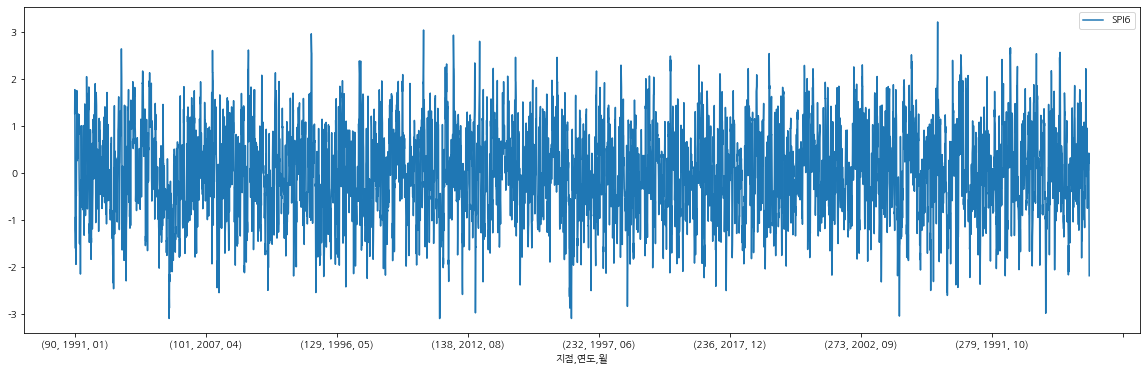

In [22]:
import seaborn as sns

spi_mean.plot(figsize=(20, 6));

In [23]:
spi_mean['SPI6'] = spi_mean['SPI6'].map(lambda x: 0 if x > -1 else 1)
spi_mean.head()

SPI6
지점 연도   월       
90 1991 01     0
        02     0
        03     0
        04     0
        05     1

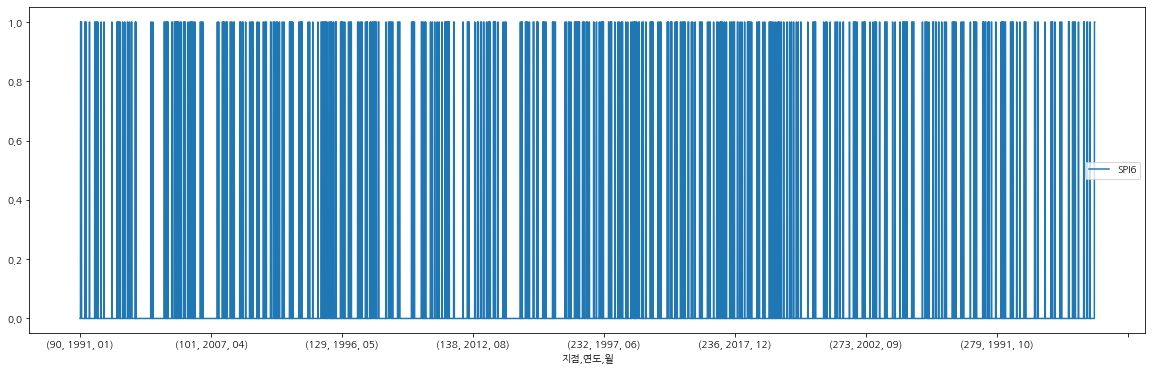

In [24]:
spi_mean.plot.line(figsize=(20, 6));

In [25]:
train_data = pd.merge(asos_mean_rolling, spi_mean, on=['지점', '연도', '월']).dropna()
train_data.head()

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                     
90 1991 01  12.095143  8.574409  16.091595  1016.753387  5.460573  2.996685   
        02   7.983546  4.363387  12.017325  1018.632016  5.017083  3.173643   
        03   5.446001  1.862258   9.409816  1019.291013  1.965040  3.280991   
        04   4.738026  1.067294   8.678651  1018.344597  1.681832  3.362102   
        05   5.465911  1.676810   9.428436  1016.539203  1.300721  3.318285   

                 이슬점       상대습도  SPI6  
지점 연도   월                              
90 1991 01  6.185932  69.743889     0  
        02  1.150237  64.995291     0  
        03 -1.793742  62.777172     0  
        04 -2.867541  61.565291     0  
        05 -2.171860  61.805649     1

In [38]:
train_data_drop = train_data.drop(['강수량'], axis=1).copy()

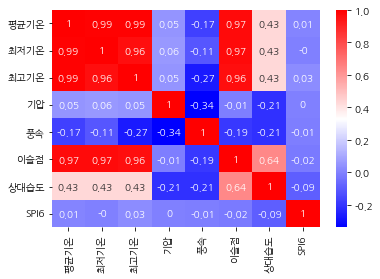

In [39]:
correlation_matrix = train_data_drop.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='bwr');

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np

X = train_data.drop(['SPI6'], axis=1)
y = train_data['SPI6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

np.unique(y_train, return_counts=True)

(array([0, 1]), array([5289,  906]))

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

drought_tree = DecisionTreeClassifier(random_state=13, max_depth=4)
drought_tree.fit(X_train, y_train)
pred = drought_tree.predict(X_test)

accuracy_score(y_test, pred)

0.8534538411878632

In [29]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : range(2, 12)
}

grid_cv = GridSearchCV(drought_tree, param_grid=params, scoring='accuracy', cv=5, return_train_score=True)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=4, random_state=13),
             param_grid={'max_depth': range(2, 12)}, return_train_score=True,
             scoring='accuracy')

In [30]:
grid_cv.best_score_

0.8944309927360775

In [31]:
grid_cv.best_params_

{'max_depth': 6}

In [32]:
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
cv_result_df[['param_max_depth', 'mean_test_score', 'mean_train_score']]

,param_max_depth,mean_test_score,mean_train_score
0,2,0.866505,0.868079
1,3,0.870218,0.875141
2,4,0.887167,0.894552
3,5,0.888943,0.904641
4,6,0.894431,0.917514
5,7,0.889911,0.925020
6,8,0.893624,0.937813
7,9,0.887490,0.950525
8,10,0.887813,0.960452
9,11,0.888297,0.969935


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': range(2, 12),
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12]
}

drought_forest = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(drought_forest, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 12), 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

In [34]:
grid_cv.best_score_

0.8807108463948015